In [25]:
import sklearn as sk
import scipy as sp
import pandas as pd
import mne
import mne_connectivity
import mne.viz
import numpy as np
import matplotlib.pyplot as plt

In [26]:
#Load a mat file and corresponding metadata
example_mat = sp.io.loadmat('data/20110706/LFP_ch1.mat')
example_time_info = sp.io.loadmat('data/20110706/Movie_start_time.mat')
example_task_info = sp.io.loadmat('data/20110706/Task_info.mat')

example_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI, Created on: Thu Jul  7 19:42:14 2011',
 '__version__': '1.0',
 '__globals__': [],
 'LFP': array([[-136, -123, -122, ...,  -38,  -20,   -5]], dtype=int16)}

In [27]:
#given a directory, load the LFP files in that directory as channels
data = []
directory = "20100708"

for i in range(128):
    file_num = i + 1
    file_name = "data/" + directory + "/" + "LFP_ch" + str(file_num) + ".mat"
    mat = sp.io.loadmat(file_name)
    data.append(mat["LFP"][0])

data = np.transpose(data)

In [28]:
#given a directory, load the ECoG files in that directory as channels
data = []
directory = "20100615S1_EMT_K2_YasuoNagasaka-ZenasChao_mat_ECoG128-Event3-Eye9"

for i in range(128):
    file_num = i + 1
    file_name = "data/" + directory + "/" + "ECoG_ch" + str(file_num) + ".mat"
    key_name = "ECoGData_ch" + str(file_num)
    mat = sp.io.loadmat(file_name)
    data.append(mat[key_name][0])

data = np.transpose(data)

In [29]:
#perform PCA on the data matrix
from sklearn.decomposition import PCA

pca = PCA(0.9)
pca.fit(data)
num_components = pca.n_components_
pca_matrix = pca.transform(data)
pca_matrix

array([[ -317.13802431,  -205.26757794,   389.46054606, ...,
          140.17674278,   210.14698651,   -71.04987274],
       [ -462.82068471,   -85.87709717,   402.82203493, ...,
          131.62626229,   272.69151251,   -45.40821016],
       [ -604.10382519,    73.70555376,   417.80922876, ...,
          174.76928523,   284.99060855,   -41.23305795],
       ...,
       [-1741.97269689,  -677.39642271,   535.16914288, ...,
         -216.52411908,  -254.89408299,   -55.55312918],
       [-1630.55325302,  -762.99442861,   543.94702849, ...,
         -206.89298803,  -217.58208531,   -91.49007388],
       [-1547.38944362,  -802.68831818,   493.66122506, ...,
         -185.03357834,  -158.70182031,  -108.87621578]])

In [30]:
num_components

53

In [31]:
from sklearn.decomposition import FastICA

#Perfom ICA on the raw data with the recieved number of components.
ica = FastICA(n_components=num_components)
ica.fit(data)
ica_data = ica.transform(data)

In [32]:
#load a mat file into mne
'''
we should be able to directly load a mat file with something like this, but I couldn't get it to work
    example_eeg = mne.io.read_raw_fieldtrip('data/20110706/LFP_ch1.mat', info=None, data_name='LFP')
instead I used this tutorial
https://mne.tools/stable/auto_tutorials/simulation/10_array_objs.html
'''

#create info
n_channels = num_components
sampling_freq = 1000
info = mne.create_info(n_channels, sfreq=sampling_freq)

#load the data from the scipy loaded mat:
#data would be a 2d np array where each row is loaded from one of the mat files as above
ica_data = np.transpose(ica_data)
raw = mne.io.RawArray(ica_data, info)


Creating RawArray with float64 data, n_channels=53, n_times=2166833
    Range : 0 ... 2166832 =      0.000 ...  2166.832 secs
Ready.


In [33]:
#reorganize the ICA matrix into epochs based on trial start times
events = pd.read_csv("data/20100615S1_EMT_K2_YasuoNagasaka-ZenasChao_csv_ECoG128-Event3-Eye9/Event.csv")

cons_matrix = np.transpose(ica_data)

#determine epoch length
min_epoch_len = 9999999
prev_index = 0
for i, event in events.iterrows():
    curr_index = event.EventIndex
    epoch_len = curr_index - prev_index
    prev_index = curr_index
    if epoch_len < min_epoch_len:
        min_epoch_len = int(epoch_len)

print(min_epoch_len)

#construct the final epoch matrix of shape (epochs, channels, samples)
transposed_ica = np.transpose(ica_data)
epoch_matrix = []
for i, event in events.iterrows():
    epoch_matrix.append(np.transpose(transposed_ica[int(event.EventIndex) : int(event.EventIndex) + min_epoch_len]))

#drop last incomplete entry
epoch_matrix = epoch_matrix[:-1]

7050


In [34]:
len(epoch_matrix[0][0])

7050

In [35]:
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

label_names = list(range(53))

def plotClipConnectivity(clipNum):

    clip_lookup = {
        1 : "CmRf",
        2 : "CwRf",
        3 : "ChRf",
        4 : "CmRn",
        5 : "CwRn",
        6 : "ChRn"
    }

    clip_epochs_matrix = np.array(epoch_matrix)[events[:-1].EventData == clipNum]
    clip_epochs = mne.EpochsArray(clip_epochs_matrix, info)

    con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
    con_theta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=4, fmax=8, faverage=True, verbose=False)
    con_alpha = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=8, fmax=12, faverage=True, verbose=False)
    con_beta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=13, fmax=30, faverage=True, verbose=False)

    plot_connectivity_circle(con_beta.get_data(output="dense")[:,:,0], label_names, title= clip_lookup[clipNum] + " Beta Wave Connectivity")
    plot_connectivity_circle(con_alpha.get_data(output="dense")[:,:,0], label_names, title= clip_lookup[clipNum] +" Alpha Wave Connectivity")
    plot_connectivity_circle(con_theta.get_data(output="dense")[:,:,0], label_names, title= clip_lookup[clipNum] +" Theta Wave Connectivity")
    plot_connectivity_circle(con_delta.get_data(output="dense")[:,:,0], label_names, title= clip_lookup[clipNum] +" Delta Wave Connectivity")

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/var/folders/h4/4cv1z9d55rx_jyg7_

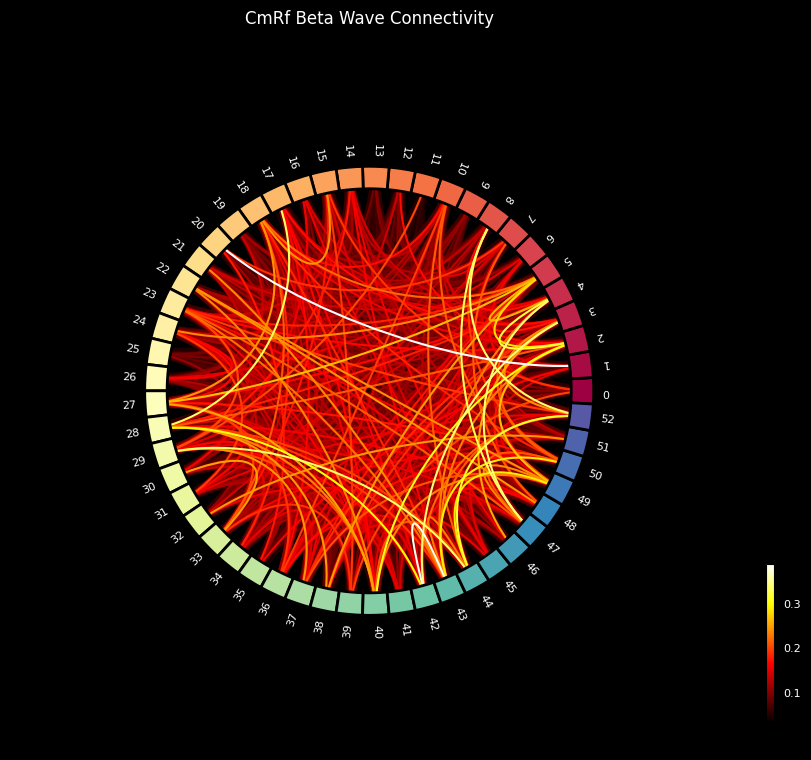

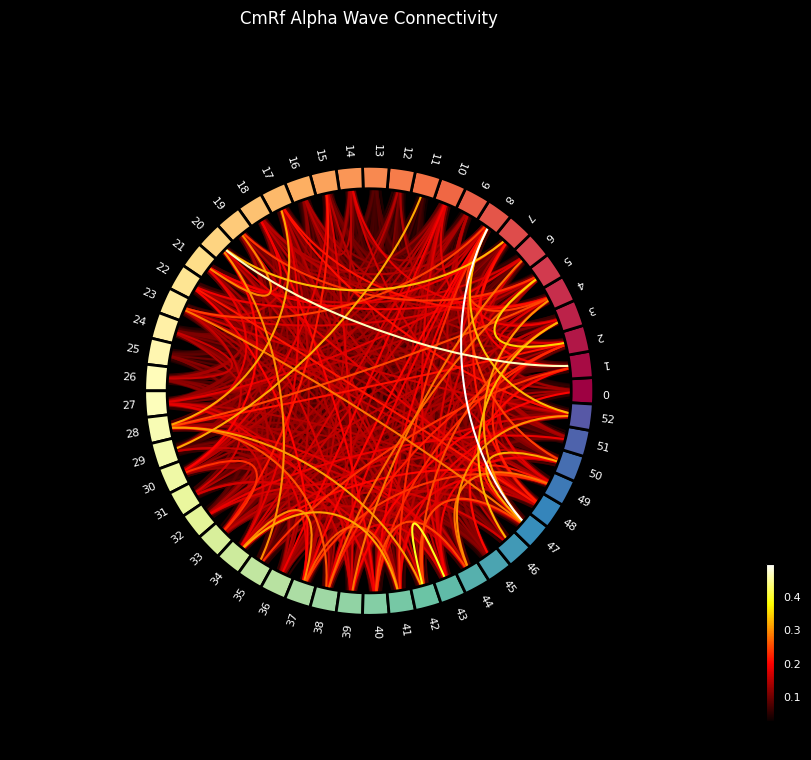

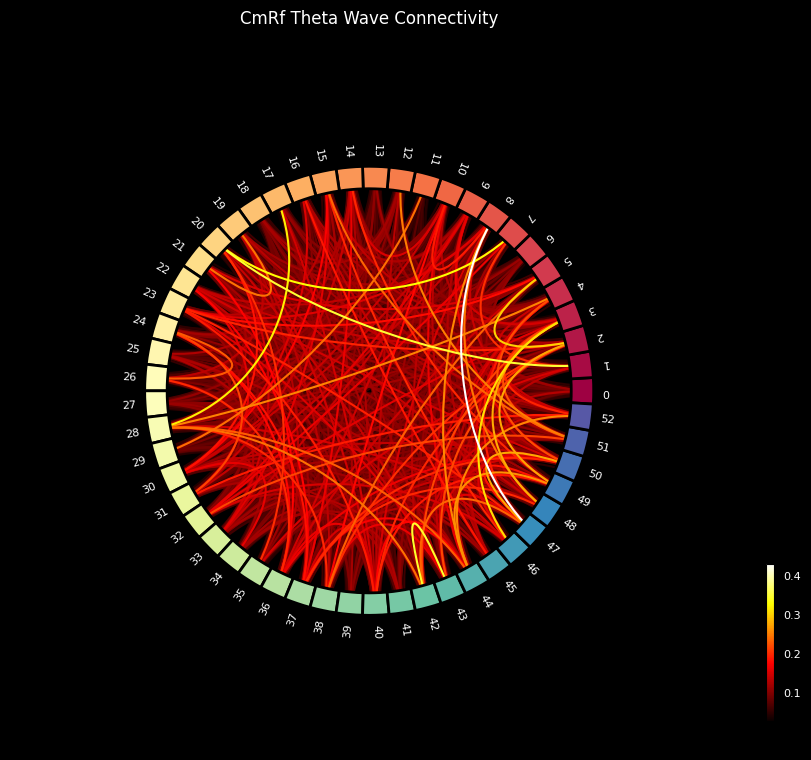

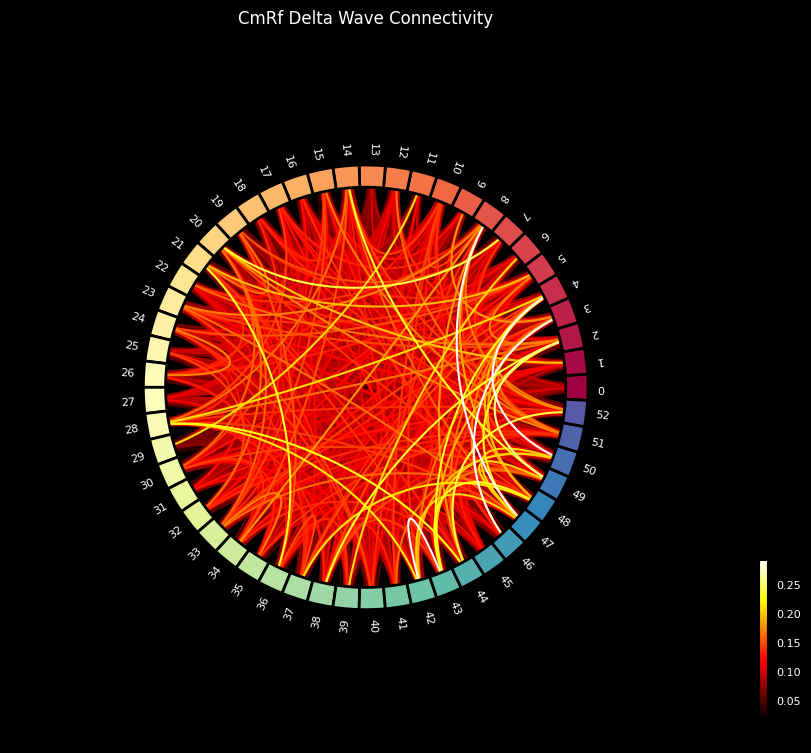

In [36]:
plotClipConnectivity(1)

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/var/folders/h4/4cv1z9d55rx_jyg7_

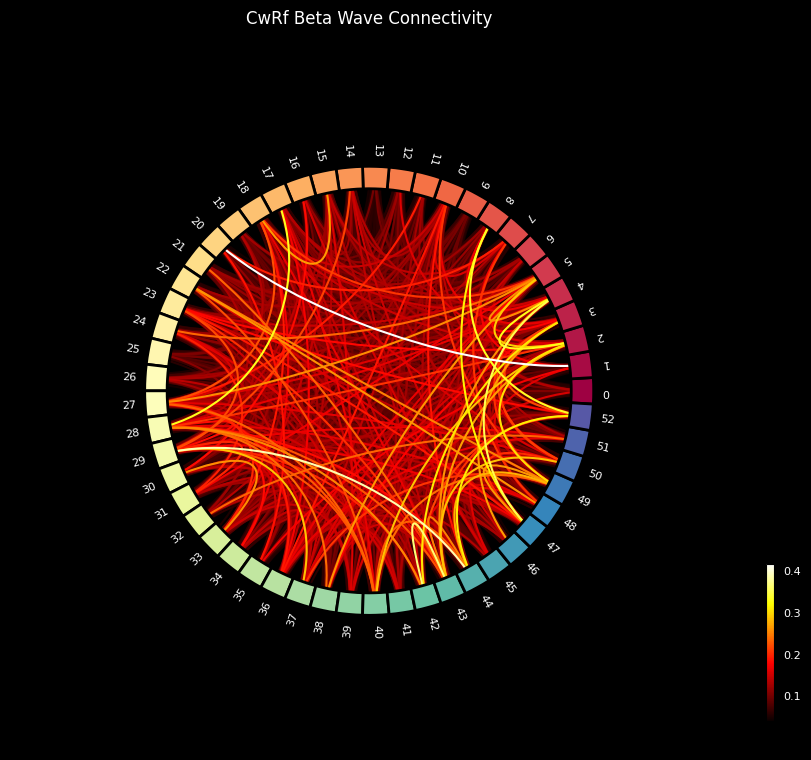

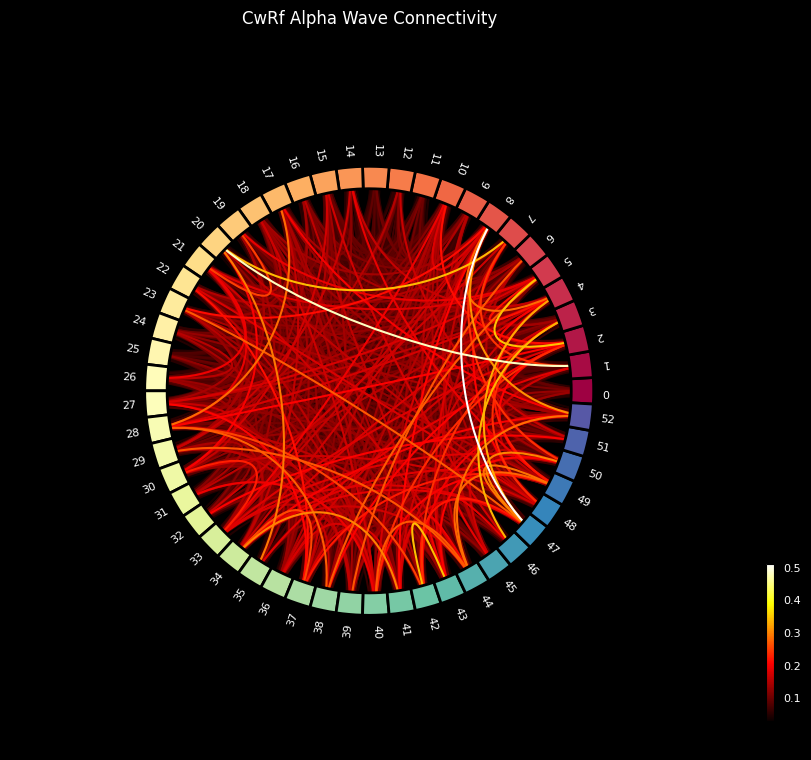

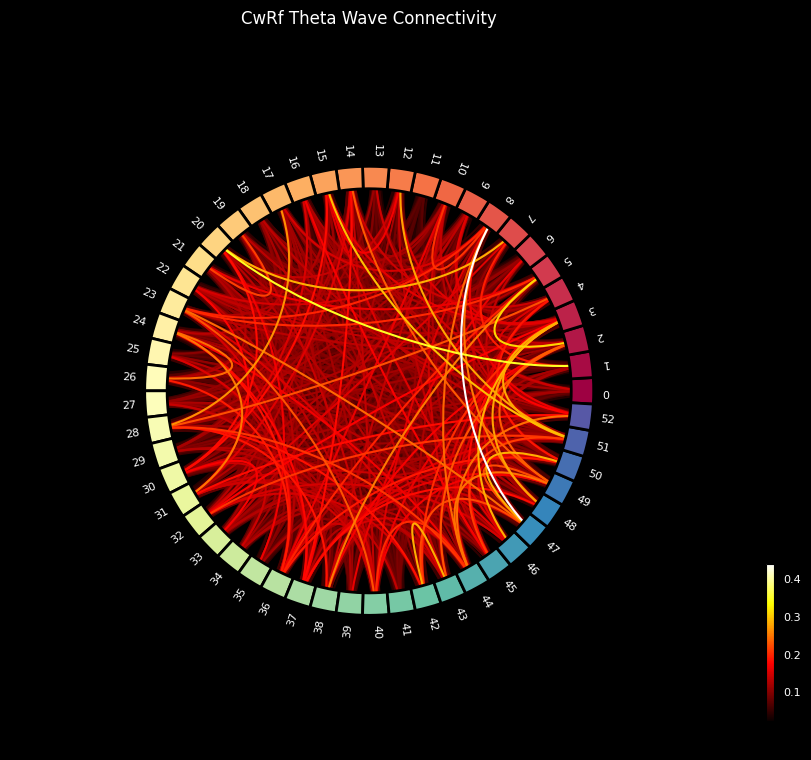

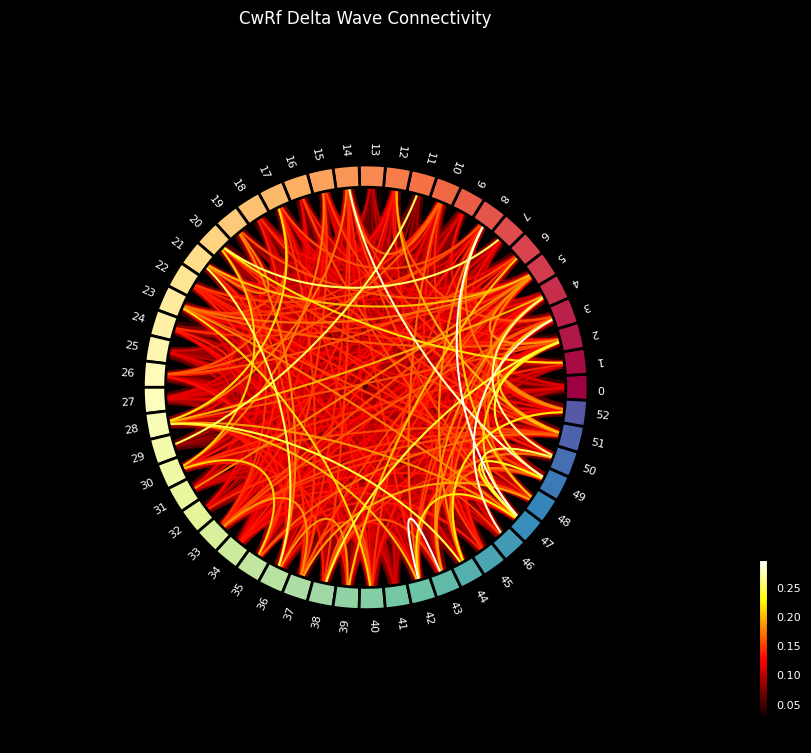

In [37]:
plotClipConnectivity(2)

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/var/folders/h4/4cv1z9d55rx_jyg7_

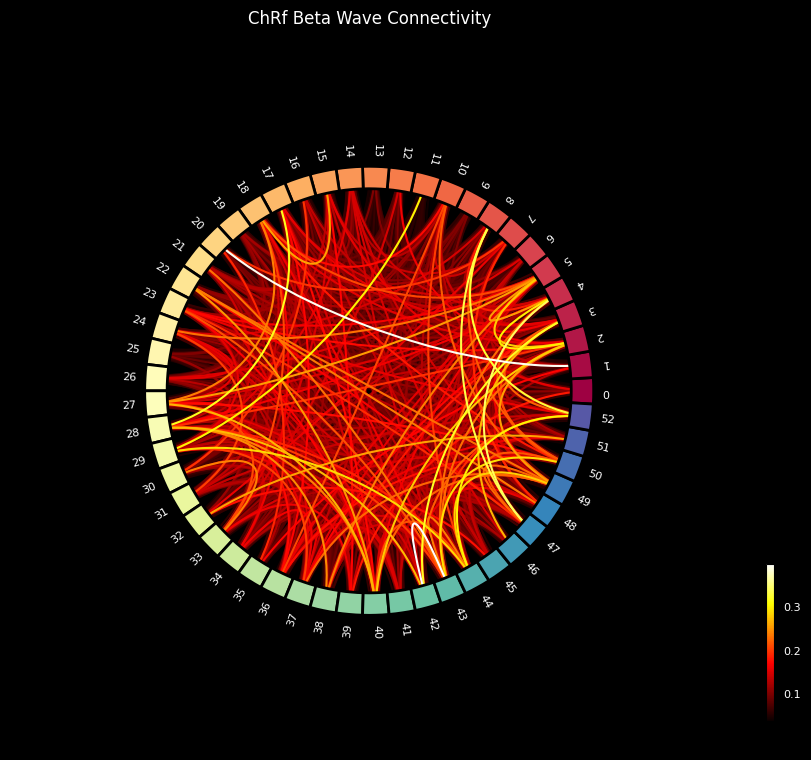

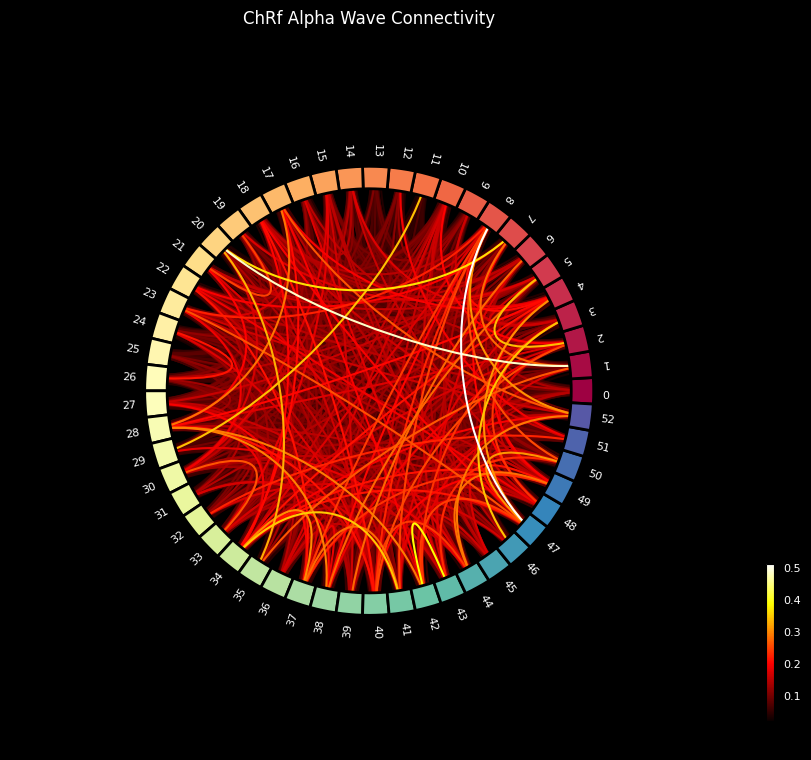

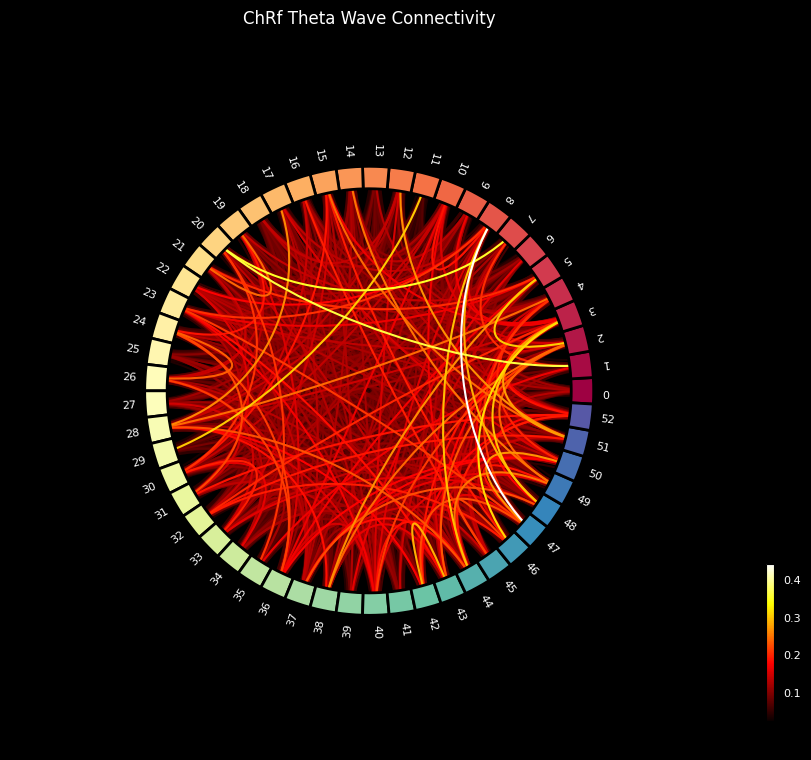

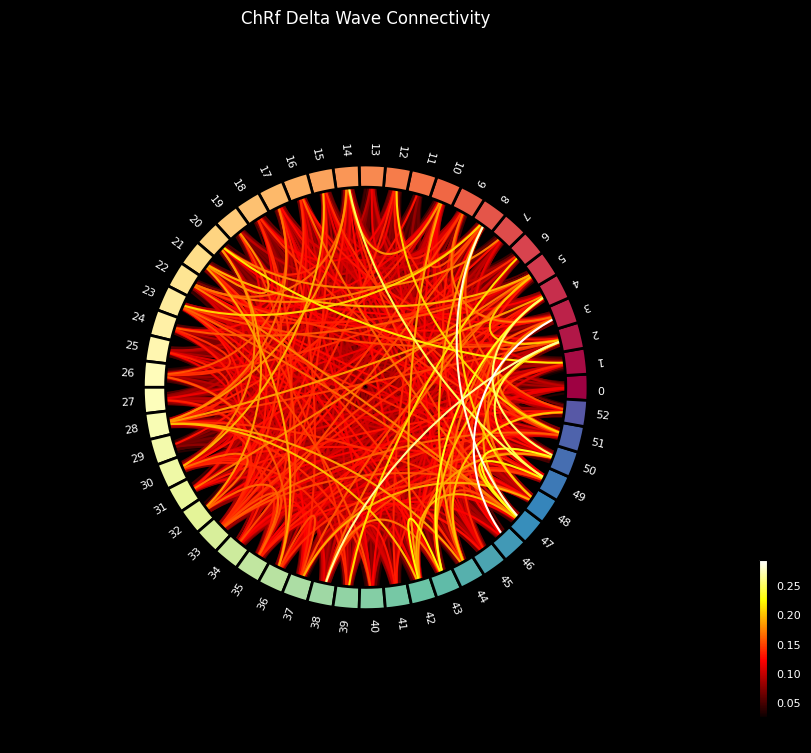

In [38]:
plotClipConnectivity(3)

Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: There were no Annotations stored in <EpochsArray |  49 events (all good), 0 – 7.049 s, baseline off, ~139.7 MB, data loaded,
 '1': 49>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/var/folders/h4/4cv1z9d55rx_jyg7_

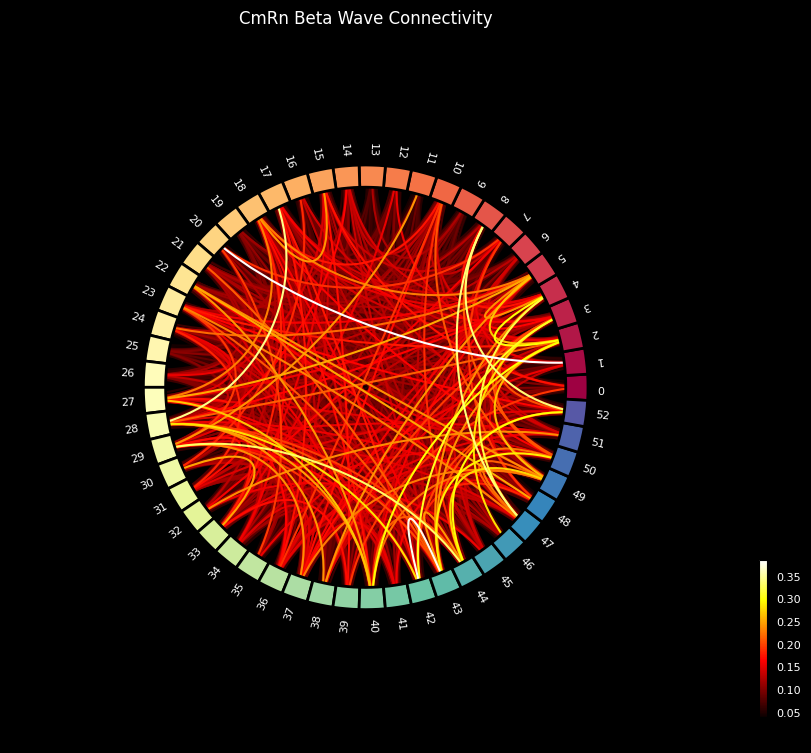

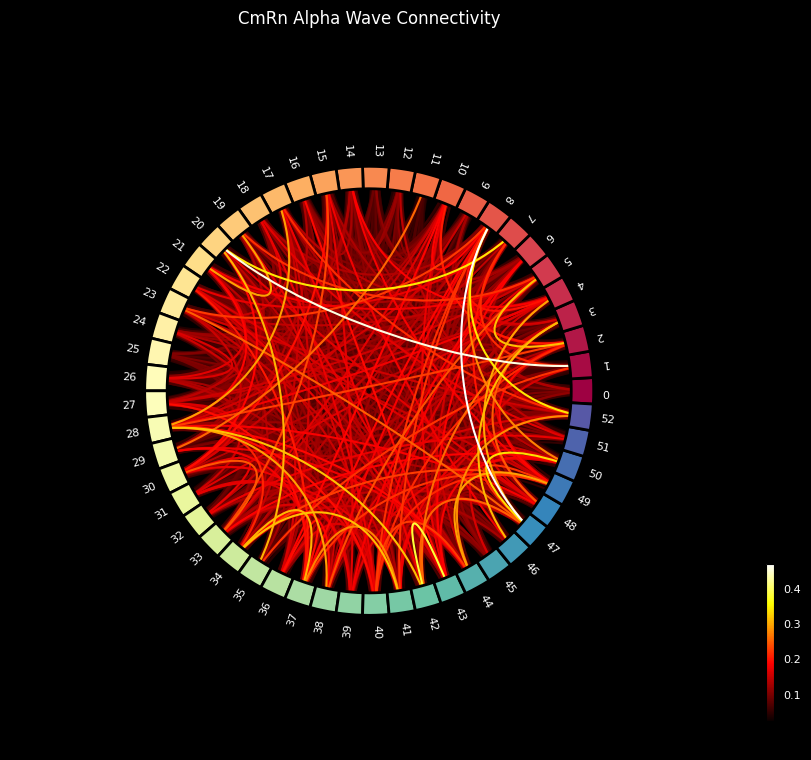

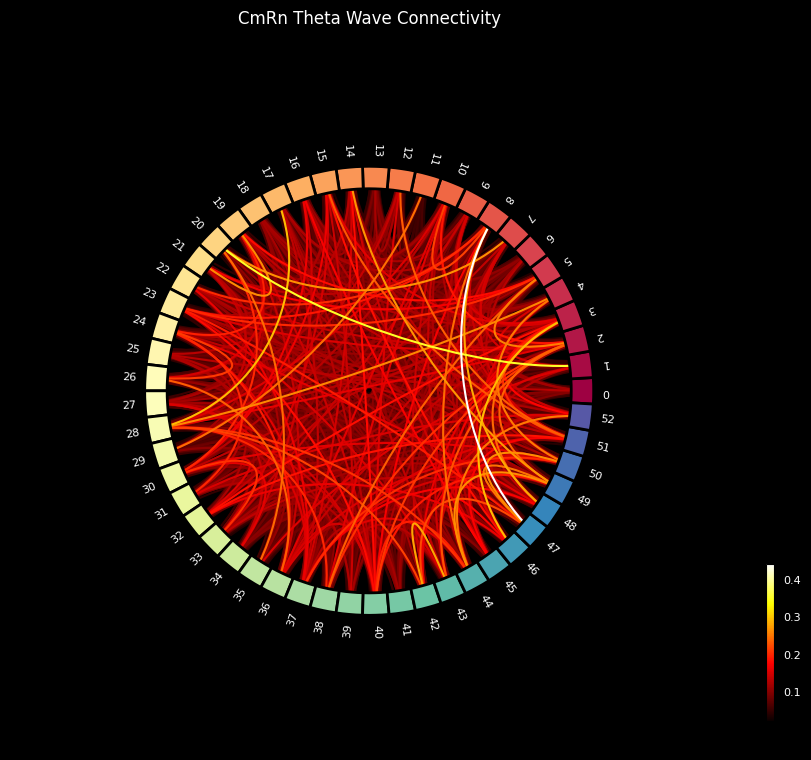

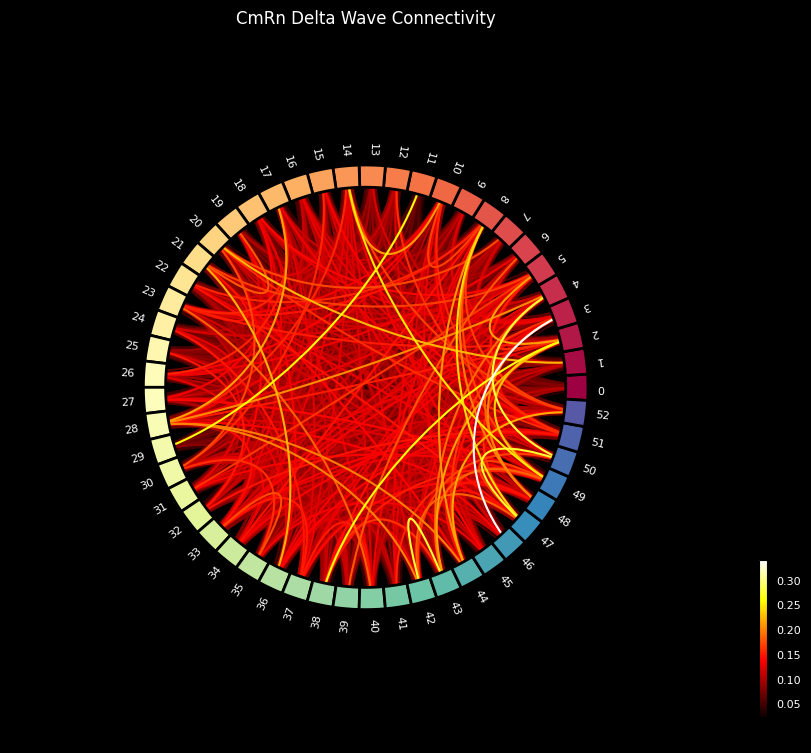

In [39]:
plotClipConnectivity(4)

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/var/folders/h4/4cv1z9d55rx_jyg7_

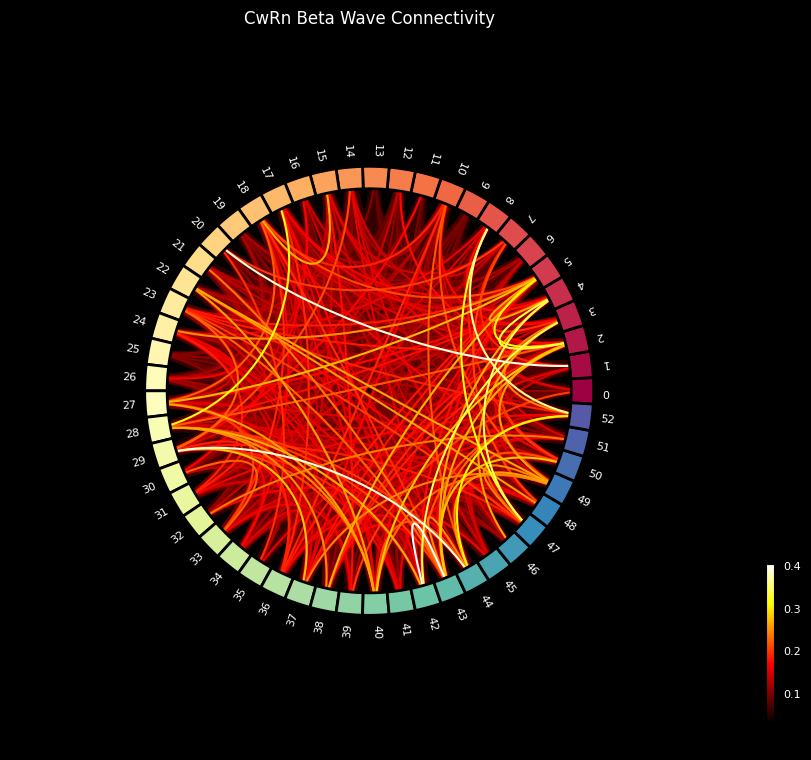

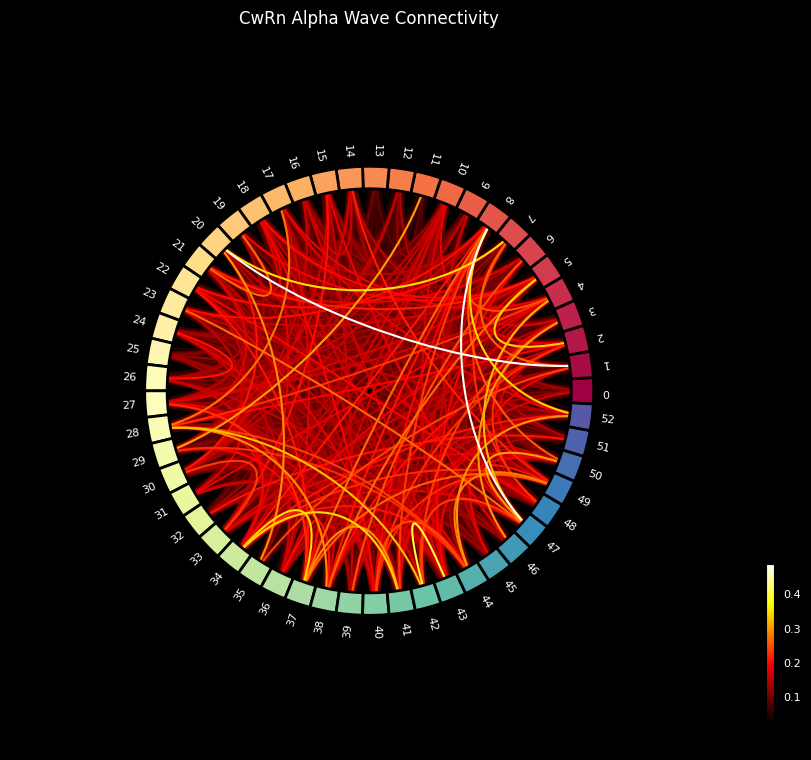

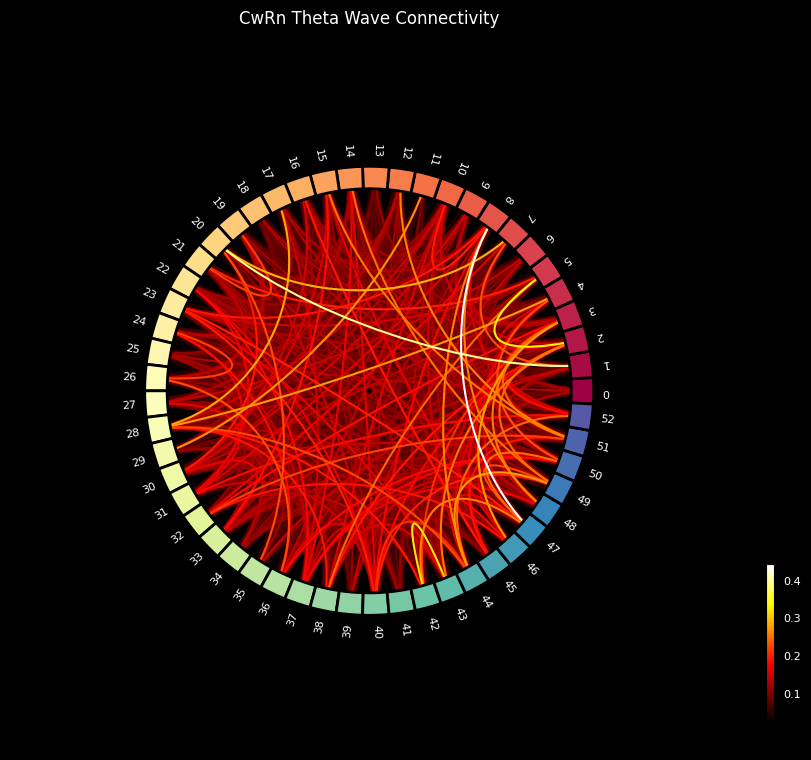

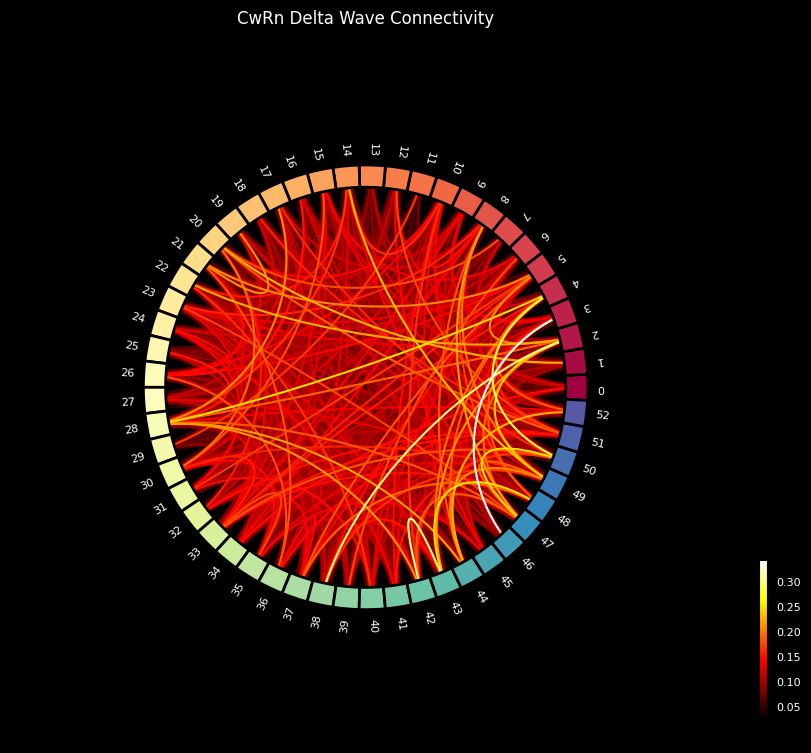

In [40]:
plotClipConnectivity(5)

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4223262318.py:20: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=4, faverage=True, verbose=False)
/var/folders/h4/4cv1z9d55rx_jyg7_

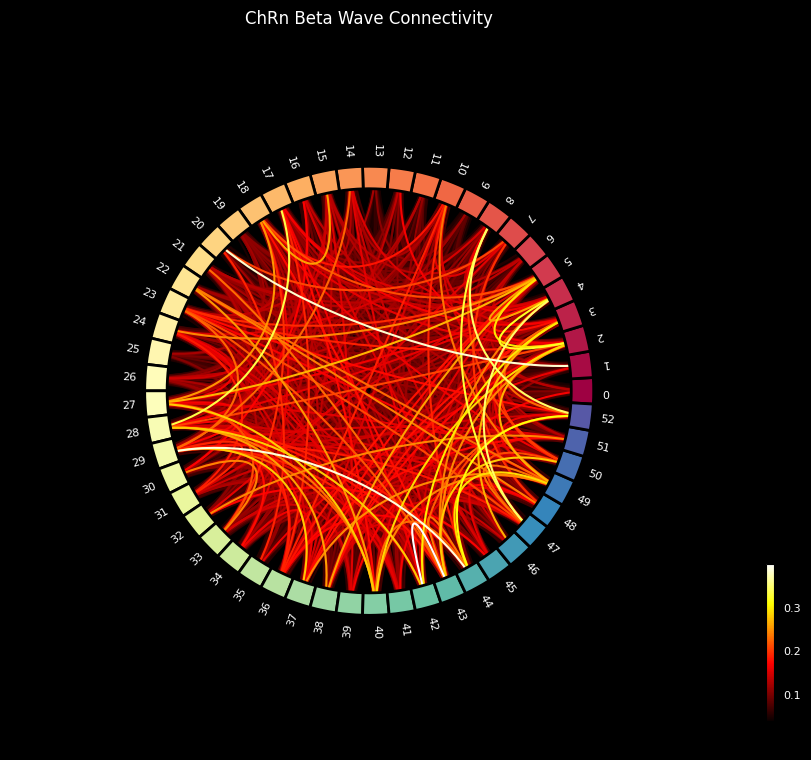

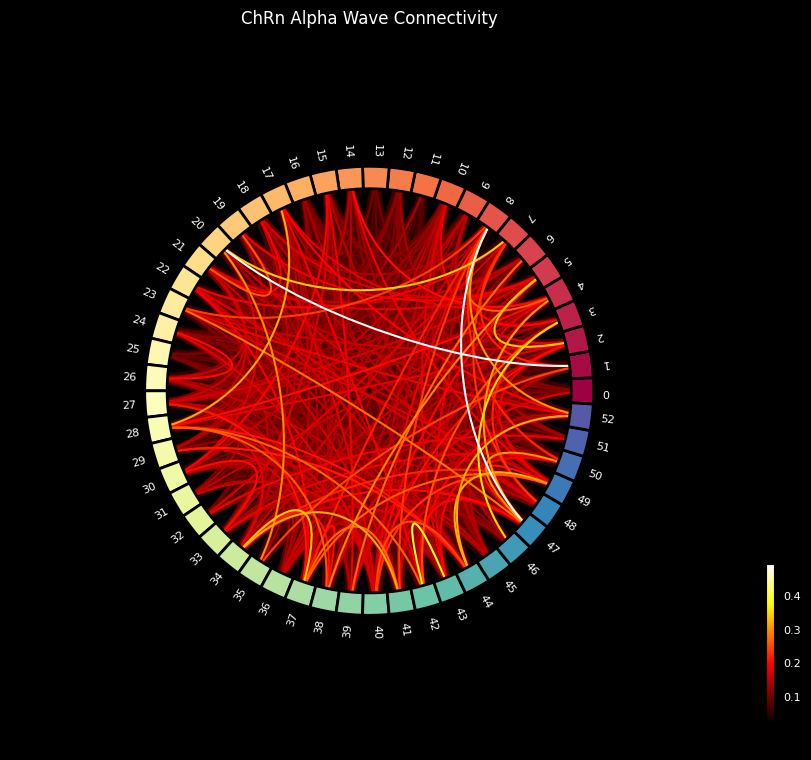

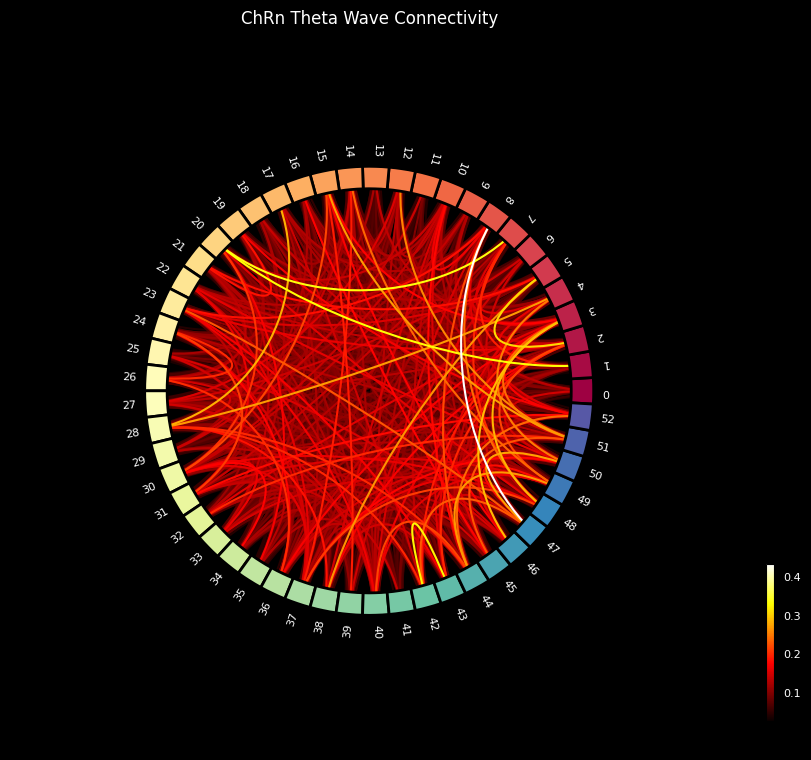

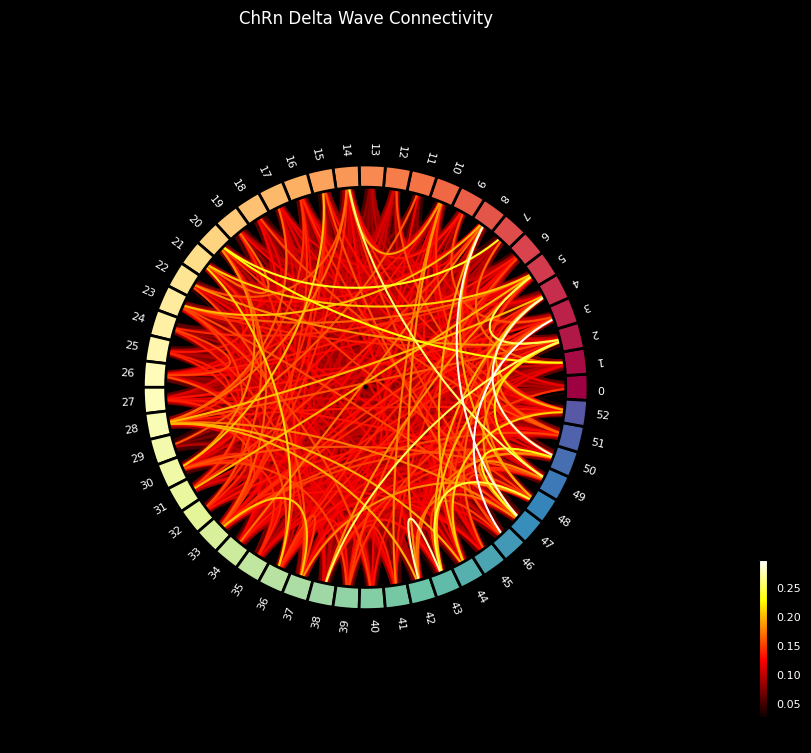

In [41]:
plotClipConnectivity(6)

Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)


Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)


Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)


Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: There were no Annotations stored in <EpochsArray |  49 events (all good), 0 – 7.049 s, baseline off, ~139.7 MB, data loaded,
 '1': 49>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)


Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)


Not setting metadata
50 matching events found
No baseline correction applied
0 projection items activated


/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: There were no Annotations stored in <EpochsArray |  50 events (all good), 0 – 7.049 s, baseline off, ~142.6 MB, data loaded,
 '1': 50>, so metadata was not modified.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)
/Users/iand/Desktop/CompNeuro/final_scratchwork/.venv/lib/python3.11/site-packages/mne_connectivity/spectral/epochs.py:186: RuntimeWarning: divide by zero encountered in scalar divide
  5.0 / np.min(fmin),
/var/folders/h4/4cv1z9d55rx_jyg7_gj_cs5r0000gn/T/ipykernel_14285/4224815918.py:5: RuntimeWarning: fmin=0.000 Hz corresponds to 0.000 < 5 cycles based on the epoch length 7.050 sec, need at least inf sec epochs or fmin=0.709. Spectrum estimate will be unreliable.
  con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)


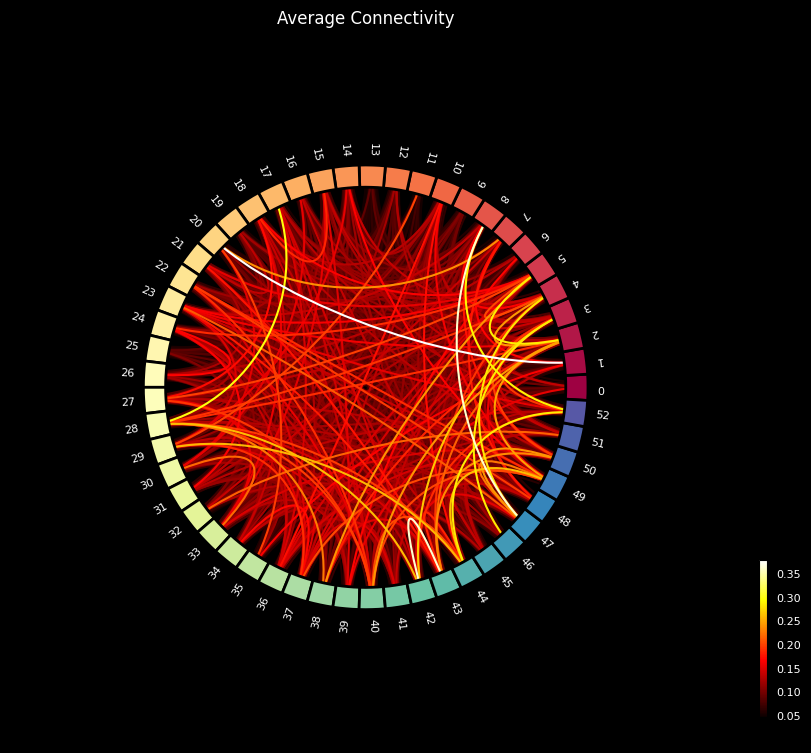

(<Figure size 800x800 with 2 Axes>,
 <PolarAxes: title={'center': 'Average Connectivity'}>)

In [42]:
#We notice a number of particularly busy cortical areas. Let's see if we can isolate them...
def getEventData(event_num):
    clip_epochs_matrix = np.array(epoch_matrix)[events[:-1].EventData == event_num]
    clip_epochs = mne.EpochsArray(clip_epochs_matrix, info)
    con_delta = spectral_connectivity_epochs(clip_epochs, method="coh", fmin=0, fmax=30, faverage=True, verbose=False)
    con_data = con_delta.get_data(output="dense")[:,:,0]
    return con_data

con1_data = getEventData(1)
con2_data = getEventData(2)
con3_data = getEventData(3)
con4_data = getEventData(4)
con5_data = getEventData(5)
con6_data = getEventData(6)

average_con_data = (con1_data + con2_data + con3_data + con4_data + con5_data + con6_data) / 6
plot_connectivity_circle(average_con_data, label_names, title="Average Connectivity")


Scratchwork for writeup:

Connectivity Measurements

N.a: Coherance Connectivity
    Talking points: equation, non-multivariate (consideres connectivity as a function of frequency), average within specific bands (alpha, beta, theta, gamma). Non-directional.

N.b: Granger Connectivity
    Talking points: equation, multivariate (inter-frequency connectivity measurement). Directional

By performing principle component analysis (PCA) on the ECoG data with a threshold of 90%, 53 independent components were identified. By performing independent component analysis (ICA), we decomposed the ECoG data to represent these independed components. These ICs are the cortical areas responsible for generating the signals registered by the ECoG sensors.

While the authors of the original paper were able to identify the physical areas represented by these ICs, we lack the experience and time needed to do so. Instead, these ICs are interpreted abstractly as arbitrary cortical areas. By performing spectral connectivity measurements, the connectivity between these arbitrary cortical areas can be visualized.

We identify 6 particularly busy ICs, rather than 7... Still, this could be a good point to bring up. These 6 ICs are likely 6 of the 7 major cortical areas identified in the paper.